TP- Recalage d'images
=============

In [1]:
import numpy as np
from scipy import signal
from scipy import interpolate
from PIL import Image
import matplotlib.pyplot as plt

Un problème fréquemment rencontré dans le domaine du traitement d’images est celui du recalage. On dispose de plusieurs images prises à des temps différents, ou par des appareils différents, et on aimerait les mettre en correspondence, c’est-à-dire trouver une déformation du plan, qui assure une correspondence point à point des objets sous-jacents. Donnons quelques exemples d’applications :
* Traitements/retouches d’images. Par exemple, on peut vouloir construire un panoramique à partir d’images de petite taille. Il faut les recaler préalablement.
* Evaluation des déplacements d’objets dans des séquences vidéos (e.g. trouver fn défaut de fonctionnement d’un organe, caméras de surveillance, design de robots intelligents ou de systèmes de navigation automatiques ...)
* Couplage d’informations. Par exemple, en imagerie médicale, on obtient une information plus riche en utilisant à la fois une radio et une angiographie. L’une apporte des informations structurelles, l’autre des informations fonctionnelles. Le couplage des deux images donne plus d’information au praticien.
* Beaucoup d’autres applications...

Dans ce TP, nous allons proposer un modèle de recalage assez élémentaire. Les idées constitutives se retrouvent cependant dans presque toutes les techniques récentes.

In [2]:
def get_images() :
    n=21
    sigma=0.3
    [X,Y]=np.meshgrid(np.linspace(-1,1,n),np.linspace(-1,1,n), indexing='xy')
    Z=np.sqrt(X*X+Y*Y)
    im1=np.zeros((n,n))
    im1[Z<=.7]=1.
    im1[Z<=.3]=.5
    im1[Z<=.1]=.7
    im2=np.zeros((n,n));
    Z=np.sqrt((X-.3)**2+(Y+.2)**2)
    im2[Z<=.7]=1
    im2[Z<=.3]=.5
    im2[Z<=.1]=.7
    G=np.fft.fftshift(np.exp(-(X**2+Y**2)/sigma**2))
    f=np.real(np.fft.ifft2(np.fft.fft2(G)*np.fft.fft2(im1)))
    g=np.real(np.fft.ifft2(np.fft.fft2(G)*np.fft.fft2(im2))) 
    f=f/np.max(f)
    g=g/np.max(g)
    return f,g,im1,im2

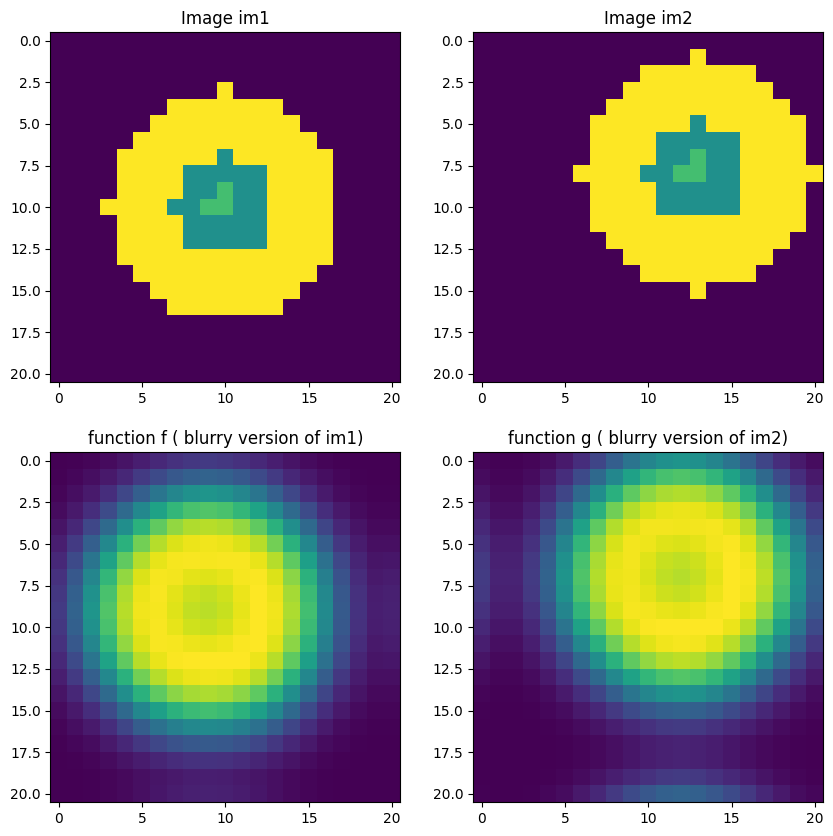

In [3]:
f,g,im1,im2=get_images()
fig, axarr = plt.subplots(2, 2, figsize=(10,10))
axarr[0,0].imshow(im1)
axarr[0,0].set_title('Image im1')
axarr[1,0].imshow(f)
axarr[1,0].set_title('function f ( blurry version of im1)')
axarr[0,1].imshow(im2)
axarr[0,1].set_title('Image im2')
axarr[1,1].imshow(g)
axarr[1,1].set_title('function g ( blurry version of im2)')
plt.show()

# 1. Formalisation du problème
## 1.1 Formalisme continu

On modélise les images en niveaux de gris comme des fonctions d’un ensemble borné $\Omega\subset \mathbb{R}$ (typiquement un carré) dans $\mathbb{R}$. La valeur de la fonction en chaque point représente l’intensité lumineuse de l’image. 

Soient $f$ et $g$ deux images. On a donc :
$$
f:\Omega\subset \mathbb{R}^2 \to \mathbb{R},  g:\Omega\subset \mathbb{R}^2 \to \mathbb{R} 
$$
En supposant que les images $f$ et $g$ dépendent seulement d’une transformation géométrique qui conserve la luminosité, le problème de recalage peut être formulé comme suit:

> Problème $(P_1)$ :
> Etant donnés $f$ et $g$ dans $H_1(\Omega)$ (les images ont une amplitude bornée et une énergie finie), trouver un champ de vecteurs $u = (u_1, u_2) \in H_1(\Omega)^2$ tel que:
> $$f(x + u(x)) = g(x), \forall x\in \Omega.$$


Le problème inverse est mal posé: tout d'abord, l'existence d'une solution n'est pas garantie, et dans le cas où il existe une solution, on n'a pas nécessairement unicité de cette solution. Par exemple, si $f$ et $g$ sont des fonctions constantes, n'importe quel déplacement $u$ est solution. Si $f$ est la constante $1$ et si $g$ est la constante $0$, il n'existe pas de solutions.

Pour le résoudre, on se propose de le reformuler comme un problème d'optimisation: 

> Problème $(P_2)$ :
> On cherche une déformation $u$ du plan qui minimise:
> $$
> E(u)=\displaystyle\frac{1}{2}\int_\Omega (f(x+u(x))-g(x))^2 dx=\frac{1}{2}\|f\circ (id+u)-g\|^2.
> $$

Sans hypothèse supplémentaire, le problème $\displaystyle \min_{u \in H^1(\Omega)^2} E(u)$ n'est a priori pas convexe, toujours mal posé et même éventuellement non différentiable si $u$ et $f$ ne sont pas assez régulières. On pourrait facilement rendre $f$ différentiable (en ajoutant du flou (on dit aussi du "bruit") par exemple à l'image, ce qui revient à convoler $f$ avec une gaussienne) mais il faut également "forcer" $u$ à être différentiable. Pour cela on propose de régulariser le problème de façon à assurer la convexité du problème d'optimisation considéré ainsi que l'existence et l'unicité des solutions.

Pour régulariser le problème inverse, nous allons faire une analogie avec l’élasticité linéaire. La fonction $u = (u_x,u_y)$ représente un champ de déformations. En notant $\partial x$ et $\partial y$ les opérateurs de dérivation partielle par rapport à chacun des axes du plan, on peut définir un potentiel élastique linéarisé :
$$
R(u)= \frac{\mu}{2}\int_{\Omega} \underbrace{ (\partial_x u_y + \partial_y u_x)^2(x,y) dxdy}_{R_1(u)=\textrm{cisaillement}} +\frac{\lambda+\mu}{2}\int_{\Omega} \underbrace{(\partial_x u_x + \partial_y u_y)^2(x,y) dxdy}_{R_2(u)=\textrm{variations  de  volume}}.
$$ 
En mécanique des structures, $\mu$ et $\lambda$ sont appelées constantes de Lamé. Le paramètre $\lambda$ n’a pas d’interprétation directe, tandis que le paramètre $\mu$ est appelé module de cisaillement.

Le problème d'optimisation à résoudre dans ce TP est le suivant:
> $$(P)\qquad \min_{u} E(u)+R(u).$$
> $$
> E(u)=\displaystyle\frac{1}{2}\int_\Omega (f(x+u(x))-g(x))^2 dx=\frac{1}{2}\|f\circ (id+u)-g\|^2.
> $$
> $$
> R(u)= \frac{\mu}{2}\int_{\Omega} \underbrace{ (\partial_x u_y + \partial_y u_x)^2(x,y) dxdy}_{R_1(u)=\textrm{cisaillement}} +\frac{\lambda+\mu}{2}\int_{\Omega} \underbrace> {(\partial_x u_x + \partial_y u_y)^2(x,y) dxdy}_{R_2(u)=\textrm{variations  de  volume}}.
> $$

**Q1.** A l'aide d'un développement de Taylor, vérifier que le gradient de $E$ s'écrit:

$$\nabla E(u) = \left(f\circ (id+u) -g\right)\nabla f\circ (id+u)$$

au sens où la différentielle de $E$ est définie par:

$$dE(u)\cdot h= \displaystyle\int_\Omega \langle (f(x+u(x))-g(x))\nabla f(x+u(x)),h(x)\rangle dx.$$

Puis par définition, on a $$ dE(u)\cdot h =\langle \nabla E(u),h\rangle \quad \forall h$$

<div style="background-color:rgba(255, 0,0, 0.1); padding:15px;">

Pour démontrer la formule du gradient de E, commençons par exprimer le développement de Taylor de $E(u + h)$ autour de u:

\begin{align*}
E(u + h) &= \frac{1}{2} \int_\Omega \left[f(x + u + h) - g(x)\right]^2 \,dx \\
&= \frac{1}{2} \int_\Omega \left[f(x + u) + \nabla f(x + u) \cdot h - g(x)\right]^2 \,dx \\
&= \frac{1}{2} \int_\Omega \left[f(x + u) - g(x)\right]^2 \,dx + \int_\Omega \left[f(x + u) - g(x)\right] \nabla f(x + u) \cdot h \,dx + \frac{1}{2} \int_\Omega \left[\nabla f(x + u) \cdot h\right]^2 \,dx \\
&= \frac{1}{2} \int_\Omega \left[f(x + u) - g(x)\right]^2 \,dx + \langle \nabla E(u),h\rangle + \mathcal{o}(\|h\|)
\end{align*}

Donc :

$$
\nabla E(u) = \left(f\circ (id+u) -g\right)\nabla f\circ (id+u)
$$
</div>

# 2. Discrétisation

Pour pouvoir résoudre numériquement le problème $(P)$ (dont les variables de l'optimisation sont des fonctions !), on propose de le discrétiser au préalable. 

Soit $1\le i \le n$ and $1\le j\le m$. Notons $(x_i,y_j)$ le point de la grille $(i,j)$ et $f_{i,j}$ la valeur de $f$ au point $(x_i,y_j)$. Le produit scalaire sur $V=\mathcal M_{n,m}(\mathbb{R})$ est défini par:
$$\langle f,g\rangle_V=\sum_{i=1}^n\sum_{j=1}^m f_{i,j}g_{i,j},$$

## 2.1. Calcul du $E$ et de son gradient
Pour pouvoir calculer $E$ et son gradient, on va avoir besoin d'évaluer $f\circ (Id+u)$ et $\nabla f\circ(id+u)$. Pour cela, vous aurez besoin de la fonction `interpol` ci-dessous.

In [4]:
def interpol(function,ux,uy) :
    # function that computes f \circ Id+u and interpolates it on a mesh
    nx,ny=f.shape
    ip=interpolate.RectBivariateSpline(np.arange(nx),np.arange(ny),function)
    [X,Y]=np.meshgrid(np.arange(nx),np.arange(ny), indexing='ij')
    X=X+ux
    Y=Y+uy
    return np.reshape(ip.ev(X.ravel(),Y.ravel()),(nx,ny))

**Q2.** Lisez la documentation de la fonction `RectBivariateSpline` afin de comprendre ce que fait la fonction `interpol`.

<div style="background-color:rgba(255, 0,0, 0.1); padding:15px;">

La fonction RectBivariateSpline fait partie du module scipy.interpolate en Python et est utilisée pour effectuer une interpolation bivariée à partir de données régulièrement espacées. Elle crée une spline bicubique basée sur des points de données bidimensionnels.
</div>

## 2.2. Calcul de $R$ et de son gradient
On discrétise également les opérateurs de dérivation partielles par différences finies ; par exemple la dérivée partielle par rapport à $x$ est donnée par, pour tout $f\in V$ par
$$\begin{cases}(\partial_x f)_{i,j}=f_{i+1,j}-f_{i,j} \text{ si } i<n \\
(\partial_x f)_{n,j}=0 \end{cases}.$$
On a ainsi $\partial_x f\in V$.

On définit les opérateurs $\partial_x^T$ et $\partial_y^T$ comme les uniques opérateurs qui vérifient

$$ \langle \partial_x^T f, g\rangle_V = \langle f,\partial_x  g\rangle_V \quad \forall f,g\in V$$
$$ \langle \partial_y^T f, g\rangle_V = \langle f,\partial_y  g\rangle_V \quad \forall f,g\in V$$

**Q2.** Donner les formules de discrétisation des opérateurs $\partial_y$, $\partial_x^\top$ et $\partial_y^\top$. Implémenter ces opérateurs ci-après. On donne un test de vérification.

<div style="background-color:rgba(255, 0,0, 0.1); padding:15px;">

On a :

\begin{align*}
\langle \partial _x f, g \rangle &= \sum_{i=1}^{n-1}\sum_{j=1}^{n}(f_{i+1,j}-f_{ij}) g_{ij}\\
&=\sum_{i=1}^{n-1}\sum_{j=1}^{n}f_{i+1,j} g_{ij}-\sum_{i=1}^{n-1}\sum_{j=1}^{n}f_{ij} g_{ij}\\
&=\sum_{i=2}^{n}\sum_{j=1}^{n}f_{i,j} g_{i-1,j}-\sum_{i=1}^{n-1}\sum_{j=1}^{n}f_{ij} g_{ij}\\
&=\sum_{i=2}^{n-1}\sum_{j=1}^{n}u_{i,j} g_{i-1,j}-\sum_{i=2}^{n-1}\sum_{j=1}^{n}u_{ij} g_{ij} - \sum_{j=1}^{n} f_{1j} g_{1j} + \sum_{j=1}^{n} f_{nj} g_{n-1,j}\\
&=\sum_{i=2}^{n-1}\sum_{j=1}^{n}f_{i,j}(g_{i-1,j}-g_{ij}) + \sum_{j=1}^{n} f_{nj} g_{n-1,j}-f_{1j} g_{1j}\\
\end{align*}

Donc : 
$$
\partial _x ^T=
\begin{cases}
    f_{i-1,j}-f_{ij} &\text{ si } i \in [2;n-1] \\
    f_{n-1,j} &\text{ si } i=n \\
    -f_{1,j} &\text{ si } i=1
\end{cases}
$$

De même,
$$
(\partial_y f)_{i,j} =
\begin{cases}
    f_{i,j+1} - f_{i,j} & \text{si } j < m \\
    0 & \text{sinon}
\end{cases}
$$
et 
$$
\partial _y ^T=
\begin{cases}
    f_{i,j-1}-f_{ij} &\text{ si } j\in [2;m-1] \\
    f_{i,n-1} &\text{ si } j=m \\
    -f_{i,1} &\text{ si } j=1
\end{cases}
$$
</div>

In [5]:
def dx(im) :
    d = np.zeros(im.shape)
    d[:-1, :] = im[1:, :] - im[:-1, :]
    return d

def dy(im) :
    d = np.zeros(im.shape)
    d[:, :-1] = im[:, 1:] - im[:, :-1]
    return d

def dyT(im) :
    d = np.zeros(im.shape)
    d[:,0]=-im[:,0]
    d[:,-1]=im[:,-2]
    d[:,1:-1]=im[:,0:-2]-im[:,1:-1]  
    return d

def dxT(im) :
    d = np.zeros(im.shape)
    d[0,:]=-im[0,:]
    d[-1,:]=im[-2,:]
    d[1:-1,:]=im[0:-2,:]-im[1:-1,:] 
    return d

def scal(a, b) :
    return np.sum(a * b)

np.random.seed(42)
im1 = np.random.randn(12, 15)
im2 = np.random.randn(12, 15)
print(scal(dx(im1), im2), '=', scal(im1, dxT(im2)))

-17.489408391382973 = -17.489408391382973


**Q3.**  On peut alors écrire :
$$
R(u)= \frac{\mu}{2}\underbrace{\sum_{i}(\partial_x u_y + \partial_y u_x)^2(i)}_{=R_1(u)} + \frac{\lambda+\mu}{2} \underbrace{\sum_i(\partial_x u_x + \partial_y u_y)^2(i)}_{=R_2(u)}.
$$ 
où:
* $u_x\in V$ et $u_y\in V$ sont les discrétisations des composantes du champ de vecteurs $u$ sur la grille choisie
* $\partial_x:V \rightarrow V$ et $\partial_y:V\rightarrow V$ représentent les opérateurs de différences finies.

On peut ré-écrire $R(u)=\frac{\mu}{2}R_1(u)+ \frac{\lambda+\mu}{2} R_2(u)$ avec : 
$$
R_1(u)=\langle A_1 u , A_1 u\rangle_V,\qquad R_2(u)=\langle A_2 u , A_2 u\rangle_V.
$$
Où $A_i$ est un opérateur de $V^2$ dans $V$.
Donnez l'expression des matrices $A_1$ et $A_2$ en fonction des opérateurs $\partial_x$ et $\partial_y$.

<div style="background-color:rgba(255, 0,0, 0.1); padding:15px;">

On a :
\begin{align*}
    R_1(u) &= \langle A_1 u , A_1 u\rangle_V  \qquad \text{ avec }
    u = \left(
    \begin{array}{c}
        u_x\\
        u_y
    \end{array}
    \right) \\
    &= \sum_{i=1}^n \sum_{j=1}^m (\left[A_1 u \right] _{ij})^2 \\
    &= \sum_{i=1}^n \sum_{j=1}^m(\left[\partial_x u_y + \partial_y u_x\right] _{ij})^2
\end{align*}

Donc :
$$
A_1 = \left(
    \begin{array}{c}
        \partial_y & \partial_x\\
    \end{array}
    \right)
$$

De même :
\begin{align*}
    R_2(u) &= \langle A_2 u , A_2 u\rangle_V  \qquad \text{ avec }
    u = \left(
    \begin{array}{c}
        u_x\\
        u_y
    \end{array}
    \right) \\
    &= \sum_{i=1}^n \sum_{j=1}^m (\left[A_2 u \right] _{ij})^2 \\
    &= \sum_{i=1}^n \sum_{j=1}^m(\left[\partial_x u_x + \partial_y u_y\right] _{ij})^2
\end{align*}

Donc :
$$
A_2 = \left(
    \begin{array}{c}
        \partial_x & \partial_y\\
    \end{array}
    \right)
$$

</div>

**Q3b.**
Pour tout $u=(u_x,u_y)$ et $v=(v_x,v_y)$ dans $V^2$, on définit le produit scalaire dans $V^2$ par
$$\langle u,v\rangle_{V^2}=\langle u_x,v_x\rangle_{V}+\langle u_y,v_y\rangle_{V}$$

Montrer que $R(u)$ peut s'écrire sous la forme:
$$R(u)=\frac{1}{2} \langle A\left(\begin{array}{c}
u_x\\
u_y
\end{array}\right),\left(\begin{array}{c}
u_x\\
u_y
\end{array}\right)\rangle_{V^2},$$

Avec $$A=\mu A_1^TA_1 +(\lambda+\mu) A_2^TA_2$$ et $A_i^T$ un opérateur de $V^2$ dans $V$.

<div style="background-color:rgba(255, 0,0, 0.1); padding:15px;">

On pose :
$$
A_1^T = \left(
    \begin{array}{c}
        \partial_y^T\\
        \partial_x^T
    \end{array}
    \right)
    \qquad
    \text{ et }
    \qquad
A_2^T = \left(
    \begin{array}{c}
        \partial_x^T\\
        \partial_y^T
    \end{array}
    \right)
$$
Soit $u = \left(
    \begin{array}{c}
        u_x\\
        u_y
    \end{array}
    \right)$ 
    
On a :
\begin{align*}
    \langle A_1^T A_1 u, u \rangle_{V^2} &= \langle \left(
        \begin{array}{cc}
            \partial_y^T \partial_y & \partial_y^T \partial_x\\
            \partial_x^T \partial_y & \partial_x^T \partial_x
        \end{array}
        \right)
        \left(
        \begin{array}{c}
            u_x\\
            u_y
        \end{array}
        \right), \left(
        \begin{array}{c}
            u_x\\
            u_y
        \end{array}
        \right) \rangle_{V^2}\\
    &= \langle \left(
        \begin{array}{c}
            \partial_y^T \partial_y u_x + \partial_y^T \partial_x u_y\\
            \partial_x^T \partial_y u_x + \partial_x^T \partial_x u_y
        \end{array}
        \right), \left(
        \begin{array}{c}
            u_x\\
            u_y
        \end{array}
        \right) \rangle_{V^2}\\
    &= \langle \partial_y^T \partial_y u_x + \partial_y^T \partial_x u_y, u_x \rangle_{V} + \langle \partial_x^T \partial_y u_x + \partial_x^T \partial_x u_y, u_y \rangle_{V}\\
    &= \langle \partial_y u_x + \partial_x u_y, \partial_y u_x \rangle_{V} + \langle \partial_y u_x + \partial_x u_y, \partial_x u_y \rangle_{V}\\
    &= \langle \partial_y u_x + \partial_x u_y, \partial_y u_x + \partial_x u_y \rangle_{V}\\
    &= \langle A_1 u, A_1 u \rangle_{V}
\end{align*}

De même :
$$
\langle A_2^T A_2 u, u \rangle_{V^2} = \langle A_2 u, A_2 u \rangle_{V}
$$

Donc, en posant $A = \mu A_1^T A_1 + (\lambda + \mu) A_2^T A_2$, on a :
\begin{align*}
    \frac{1}{2} \langle A u, u \rangle_{V^2} &= \frac{1}{2} \langle \mu A_1^T A_1 u + (\lambda + \mu) A_2^T A_2 u, u \rangle_{V^2}\\
    &= \frac{1}{2} \langle \mu A_1^T A_1 u, u \rangle_{V^2} + \frac{1}{2} \langle (\lambda + \mu) A_2^T A_2 u, u \rangle_{V^2}\\
    &= \frac{\mu}{2} \langle A_1 u, A_1 u \rangle_{V} + \frac{\lambda + \mu}{2} \langle A_2 u, A_2 u \rangle_{V}\\
    &= \frac{\mu}{2} R_1(u) + \frac{\lambda + \mu}{2} R_2(u)\\
    &= R(u)
\end{align*}

</div>

**Q4.** Donner l'expression du gradient de $R$.

<div style="background-color:rgba(255, 0,0, 0.1); padding:15px;">

On a :

$R(u) = \frac{1}{2} \langle A u, u \rangle_{V^2}$

Donc :
\begin{align*}
    R(u) &= Au \\
    &= \mu A_1^T A_1 u + (\lambda + \mu) A_2^T A_2 u\\
    &= \mu \left(
        \begin{array}{cc}
            \partial_y^T \partial_y & \partial_y^T \partial_x\\
            \partial_x^T \partial_y & \partial_x^T \partial_x
        \end{array}
        \right)
        \left(
        \begin{array}{c}
            u_x\\
            u_y
        \end{array}
        \right) + (\lambda + \mu) \left(
        \begin{array}{cc}
            \partial_x^T \partial_x & \partial_x^T \partial_y\\
            \partial_y^T \partial_x & \partial_y^T \partial_y
        \end{array}
        \right)
        \left(
        \begin{array}{c}
            u_x\\
            u_y
        \end{array}
        \right)\\
    &= \left(
        \begin{array}{cc}
            \mu \partial_y^T \partial_y + (\lambda + \mu) \partial_x^T \partial_x & \mu \partial_y^T \partial_x + (\lambda + \mu) \partial_x^T \partial_y\\
            \mu \partial_x^T \partial_y + (\lambda + \mu) \partial_y^T \partial_x & \mu \partial_x^T \partial_x + (\lambda + \mu) \partial_y^T \partial_y
        \end{array}
        \right)
        \left(
        \begin{array}{c}
            u_x\\
            u_y
        \end{array}
        \right)\\
\end{align*}

</div>

## 2.3. Implémentation de la fonction objectif $E+R$

Créez une fonction `objective_function` qui calcul $E(u)+R(u)$. 

Cette fonction prend en variable d'entrée 
* `f`,`g` et `ux` et `uy` qui sont nécessaires au calcul de $E(u)$
* `ux`,`uy` ,`lamb` et `mu` qui sont nécessaires au calcul de $R(u)$. Ici `lamb` et `mu` sont deux variables réelles positives qui représentent $\lambda$ et $\mu$. 


Cette fonction doit rendre deux arguments :
* `obj` qui est la valeur de $E(u)+R(u)$
* `fu` qui est un tableau qui représente le résultat du calcul de $f\circ(Id +u)$. On rend ce tableau car il sera utile pour les prochains calculs.

In [6]:
def objective_function(f, g, ux, uy, lamb, mu):
    # Calcul de E(u)
    fu = interpol(f, ux, uy)
    residual = fu - g
    E_u = 0.5 * np.sum(residual**2)

    # Calcul de R(u)
    R1_u = np.linalg.norm((dx(uy) + dy(ux)))**2
    R2_u = np.linalg.norm((dx(ux) + dy(uy)))**2
    R_u = 0.5 * (mu * R1_u + (lamb + mu) * R2_u)

    # Valeur de l'objectif
    obj = E_u + R_u

    return obj, fu

np.random.seed(12)
ux=np.random.randn(f.shape[0],f.shape[1])
uy=np.random.randn(f.shape[0],f.shape[1])
obj,fu=objective_function(2*f,3*g,ux,uy,10,5)
print(obj,fu.shape,np.linalg.norm(fu)) #18215.406074781582 (21, 21) 22.047265562734097

18215.406074781582 (21, 21) 22.047265562734097


## 2.4 Implémentation des gradients
Créez une fonction `gradE` et `gradR` qui calcule $\nabla E(u)$ et $\nabla R(u)$. On garde les conventions de noms de variable de la section précédente et on notera `gradxE,gradyE` les deux composantes de  $\nabla E(u)$ et `gradxR,gradyR` les deux composantes de $\nabla R(u)$. Les variables `dfx` et `dfy`contiennent les dérivées selon `x` et `y` de `f`, elles seront initalisées par `dfx=dx(f)` et `dfy=dy(f)`

In [7]:
def gradE(dfx,dfy,g,fu,ux,uy) :
    gradxE = (fu-g)*interpol(dfx,ux,uy)
    gradyE = (fu-g)*interpol(dfy,ux,uy)
    return gradxE,gradyE

def gradR(lamb,mu,ux,uy) :
    gradxR = mu*dyT(dy(ux)) + (lamb + mu)*dxT(dx(ux)) + mu*dyT(dx(uy)) + (lamb + mu)*dxT(dy(uy))
    gradyR = mu*dxT(dx(uy)) + (lamb + mu)*dyT(dy(uy)) + mu*dxT(dy(ux)) + (lamb + mu)*dyT(dx(ux))
    return gradxR,gradyR

In [8]:
dfx=dx(f)
dfy=dy(f)  
np.random.seed(12)
ux=np.random.randn(f.shape[0],f.shape[1])
uy=np.random.randn(f.shape[0],f.shape[1])
obj,fu=objective_function(f,g,ux,uy,10,5)
gradxE,gradyE=gradE(dfx,dfy,g,fu,ux,uy)
print(gradxE.shape,gradyE.shape) #(21, 21) (21, 21)
print(np.linalg.norm(gradxE),np.linalg.norm(gradyE)) #0.6513993385167333 0.6040320505869908
gradxR,gradyR=gradR(10.,5.,ux,uy) 
print(gradxR.shape,gradyR.shape)  #(21, 21) (21, 21)
print(np.linalg.norm(gradxR),np.linalg.norm(gradyR)) #1180.7792368512296 1239.1880693357143

(21, 21) (21, 21)
0.6513993385167333 0.6040320505869909
(21, 21) (21, 21)
1180.7792368512296 1239.1880693357143


# 3. Un algorithme de gradient

Une itération de la méthode de descente de gradient est de la forme:

$$
u_{k+1}=u_k-s_k(\nabla E(u) + \nabla R(u))
$$

**Q5.** Compléter la fonction RecalageDG implémentant la descente de gradient et utilisant l'algorithme de recherche linéaire par rebroussement proposé ci-dessous.

In [9]:
def linesearch(ux,uy,step,descentx,descenty,obj_old,f,g,lamb,mu) :
    step=2*step
    tmpx=ux-step*descentx
    tmpy=uy-step*descenty
    obj,fu=objective_function(f,g,tmpx,tmpy,lamb,mu)
    while obj >obj_old and step > 1.e-8:
        step=0.5*step
        tmpx=ux-step*descentx
        tmpy=uy-step*descenty
        obj,fu=objective_function(f,g,tmpx,tmpy,lamb,mu)
    return tmpx,tmpy,step


def RecalageDG(f, g, lamb, mu, nitermax, stepini):
    ux = np.zeros(f.shape)
    uy = np.zeros(f.shape)
    CF = []
    step_list = []
    dfx = dx(f)
    dfy = dy(f)
    niter = 0
    step = stepini
    while niter < nitermax and step > 1.e-8:
        niter += 1
        obj, fu = objective_function(f, g, ux, uy, lamb, mu)
        CF.append(obj)
        
        gradxE, gradyE = gradE(dfx, dfy, g, fu, ux, uy)
        gradxR, gradyR = gradR(lamb, mu, ux, uy)
        
        gradx = gradxE + gradxR
        grady = gradyE + gradyR
        
        ux, uy, step = linesearch(ux, uy, step, gradx, grady, obj, f, g, lamb, mu)
        step_list.append(step)

        if niter % 3 == 0:
            print('iteration :', niter, ' cost function :', obj, 'step :', step)
    return ux, uy, np.array(CF), np.array(step_list)

**Q5.** Ecrire un compte-rendu des expériences réalisées et des résultats obtenus. Commentez.

In [10]:
lamb=10
mu=20
nitermax=500

step0 = 0.01
ux,uy,CF,step=RecalageDG(f,g,lamb,mu,nitermax,step0)
# la premiere ligne est 
# iteration : 3  cost function : 19.08125492560699 step : 0.08

iteration : 3  cost function : 19.081254925606988 step : 0.08
iteration : 6  cost function : 19.04274372706119 step : 0.02
iteration : 9  cost function : 19.031367910404178 step : 0.01
iteration : 12  cost function : 19.024123838887235 step : 0.01
iteration : 15  cost function : 19.018062108808866 step : 0.01
iteration : 18  cost function : 19.01253459257595 step : 0.005
iteration : 21  cost function : 19.00855384412729 step : 0.005
iteration : 24  cost function : 19.00309484902698 step : 0.005
iteration : 27  cost function : 18.998331455413652 step : 0.005
iteration : 30  cost function : 18.993817208909185 step : 0.005
iteration : 33  cost function : 18.989426139703767 step : 0.005
iteration : 36  cost function : 18.985108875837863 step : 0.01
iteration : 39  cost function : 18.981933800643713 step : 0.005
iteration : 42  cost function : 18.977325922524493 step : 0.005
iteration : 45  cost function : 18.972843826776028 step : 0.005
iteration : 48  cost function : 18.968449166662534 st

iteration : 447  cost function : 18.472341299196184 step : 0.005
iteration : 450  cost function : 18.468658357069977 step : 0.005
iteration : 453  cost function : 18.46499827177824 step : 0.005
iteration : 456  cost function : 18.461359301832076 step : 0.005
iteration : 459  cost function : 18.457739487646954 step : 0.005
iteration : 462  cost function : 18.454137409043987 step : 0.005
iteration : 465  cost function : 18.450551431562154 step : 0.005
iteration : 468  cost function : 18.44698039845159 step : 0.005
iteration : 471  cost function : 18.443422944852806 step : 0.005
iteration : 474  cost function : 18.43987812985523 step : 0.005
iteration : 477  cost function : 18.436344812288773 step : 0.005
iteration : 480  cost function : 18.432822227965868 step : 0.005
iteration : 483  cost function : 18.42930942142908 step : 0.005
iteration : 486  cost function : 18.42580577307311 step : 0.005
iteration : 489  cost function : 18.42231048173005 step : 0.005
iteration : 492  cost function 

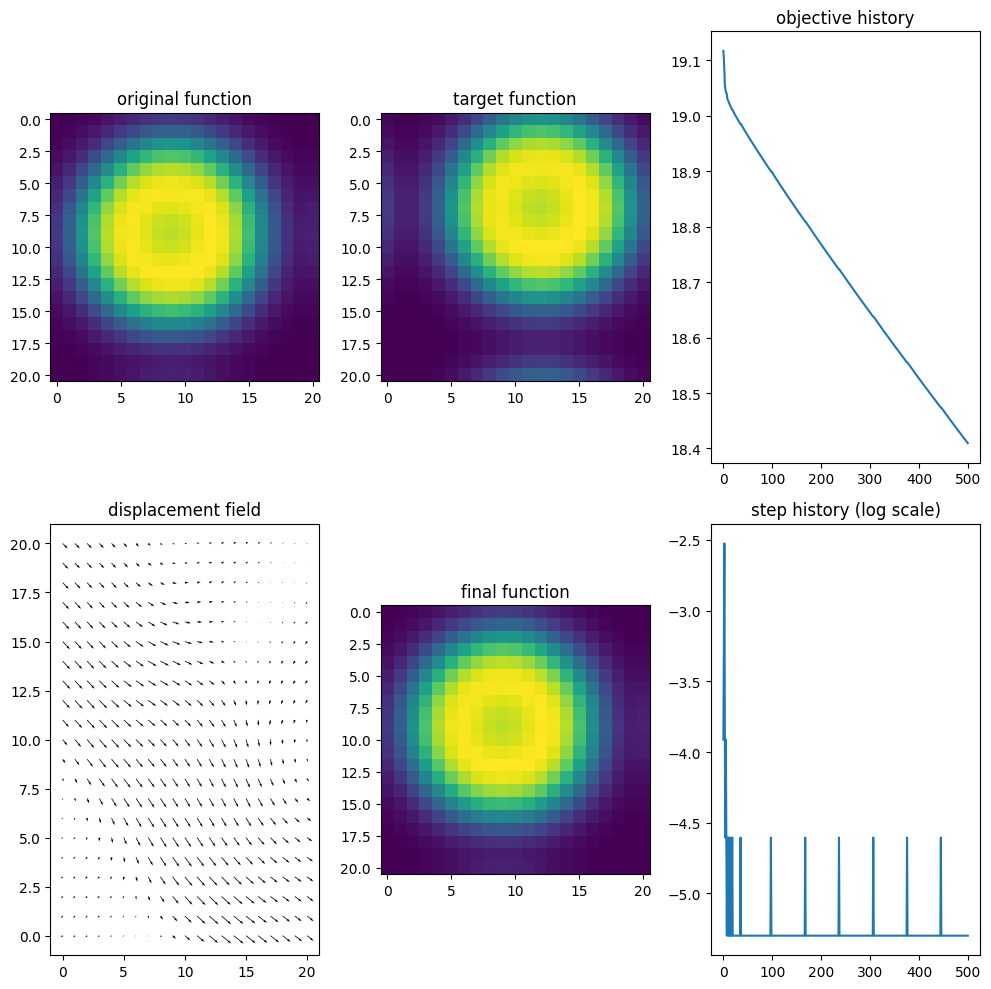

In [11]:
fig, ax = plt.subplots(2,3, figsize=(10,10))
ax[0,0].imshow(f)
ax[0,0].set_title('original function')
ax[0,1].imshow(g)
ax[0,1].set_title('target function')
ax[1,0].quiver(ux,uy)
ax[1,0].set_title('displacement field')
ax[1,1].imshow(interpol(f,ux,uy))
ax[1,1].set_title('final function')
ax[0,2].plot(CF)
ax[0,2].set_title('objective history')
ax[1,2].plot(np.log(step))
ax[1,2].set_title('step history (log scale)')

plt.tight_layout()
plt.show()

<div style="background-color:rgba(255, 0,0, 0.1); padding:15px;">

On va rechercher un $\lambda$ et un $\mu$ optimaux qui permettent de faire converger l'algorithme en le moins d'itérations possible. Pour cela, on va tester la fonction $\texttt{RecalageDG}$ avec plusieurs valeurs de $\lambda$ et conserver celle qui a le $\texttt{niter}$ le plus petit possible.
</div>

# 4. Algorithme de moindres carrés.

On souhaite maintenant implémenter un algorithme de second ordre pour résoudre le problème $$(P)\quad\min_u E(u)+R(u)$$ afin d'accélérer la convergence de l'algorithme. Pour cela, on va reformuler le problème $(P)$ en un problème de moindres carrés et appliquer l'algorithme de Levenberg-Marquardt.

Soit:
$$\Psi(u)=\begin{pmatrix} 
f\circ(Id+u)-g \\ 
\sqrt{\mu}(\partial_xu_y+\partial_yu_x) \\ 
\sqrt{\mu+\lambda}(\partial_xu_x+\partial_yu_y) \end{pmatrix},$$
où $f\circ(id+u)$ est l'interpolation de $x\mapsto f(x+u(x))$ sur la grille. Minimiser $E(u)+R(u)$ est équivalent à résoudre le problème suivant:

>$$\min_u \|\Psi(u)\|_2^2.$$

Il s'agit maintenant d'un problème de moindres carrés que l'on va résoudre à l'aide de l'algorithme de Levenberg Marquardt :

$$
u_{k+1}=u_k- H_k^{-1} J_{\Psi}(u_k)^\top \Psi(u_k) \quad{ avec }\quad H_k=J_{\Psi}(u_k)^\top J_{\Psi}(u_k) +\varepsilon Id
$$

**Q6.** Calculer la matrice jacobienne de $\Psi$, notée $J_\Psi(u)$.

<div style="background-color:rgba(255, 0,0, 0.1); padding:15px;">

$$\Psi(u)=\begin{pmatrix} 
\Psi_1(u) \\ 
\Psi_2(u) \\ 
\Psi_3(u) \end{pmatrix}, \quad
\Leftrightarrow \quad J_{\Psi}(u) = \begin{pmatrix} 
J_{\Psi_1}(u) \\ 
J_{\Psi_2}(u) \\ 
J_{\Psi_3}(u) \end{pmatrix}
$$


- $\Psi_1(u) = f\circ (Id+u) - g \quad \Leftrightarrow \quad J_{\Psi_1}(u)= (\nabla f\circ (Id+u))^\top$

- $\Psi_2(u) = \sqrt{\mu}(\partial_xu_y+\partial_yu_x) \quad \Leftrightarrow \quad J_{\Psi_2}(u) = \begin{pmatrix}
\sqrt{\mu} \partial_y & \sqrt{\mu} \partial_x
\end{pmatrix}$

- $\Psi_3(u) = \sqrt{\mu+\lambda}(\partial_xu_x+\partial_yu_y) \quad \Leftrightarrow \quad J_{\Psi_3}(u) = \begin{pmatrix}
\sqrt{\mu+\lambda} \partial_x & \sqrt{\mu+\lambda} \partial_y
\end{pmatrix}$

Donc :

$$
J_\Psi(u) = \left(
    \begin{array}{c}
        (\nabla f\circ (id+u))^\top\\
        \sqrt{\mu} \left(
            \begin{array}{cc}
                \partial_y & \partial_x
            \end{array}
            \right)\\
        \sqrt{\mu + \lambda} \left(
            \begin{array}{cc}
                \partial_x & \partial_y
            \end{array}
            \right)
    \end{array}
    \right)
$$

</div>

**Q7.** Implémenter les fonctions `Psi`,`JPsi`, `JTPsi` et `JTJ` qui calculent respectivement:
- La valeur de $\Psi(u)$
- le produit de $J_\Psi(u)$ par une direction $v=(v_x,v_y)\in V^2$,

- le produit de $J_\Psi(u)^\top$ par $\phi=(\phi_1,\phi_2,\phi_3)\in V^3$,

- le produit de $(J_\Psi(u)^\top J_\Psi(u)+\epsilon I)$ par une direction $v=(v_x,v_y)\in V^2$.


Par convention `fu` représente $f\circ(Id+u)$ et `dfxu`et `dfyu` représentent les deux coordonnées de $(\nabla f)\circ(Id +u)$. On vous donne dans la cellulle suivante des tests de vérification.

In [12]:
def Psi(fu, g, ux, uy, lamb, mu):
    Psi0 = fu - g
    Psi1 = np.sqrt(mu) * (dy(ux) + dx(uy))
    Psi2 = np.sqrt(mu + lamb) * (dx(ux) + dy(uy))
    return Psi0, Psi1, Psi2

def JPsi(vx, vy, dfxu, dfyu, lamb, mu):
    JPsi0 = dfxu * vx + dfyu * vy
    JPsi1 = np.sqrt(mu) * (dy(vx) + dx(vy))
    JPsi2 = np.sqrt(mu + lamb) * (dx(vx) + dy(vy))
    return JPsi0, JPsi1, JPsi2

def JTPsi(phi, dfxu, dfyu, lamb, mu):
    ux = phi[0]*dfxu + np.sqrt(mu)*dyT(phi[1]) + np.sqrt(mu+lamb)*dxT(phi[2])
    uy = phi[0]*dfyu + np.sqrt(mu)*dxT(phi[1]) + np.sqrt(mu+lamb)*dyT(phi[2])
    return ux, uy

def JTJ(vx, vy, dfxu, dfyu, lamb, mu, epsilon):
    uxs, uys = JTPsi(JPsi(vx,vy,dfxu, dfyu,lamb,mu),dfxu, dfyu,lamb,mu)
    uxs = uxs + epsilon*vx
    uys = uys + epsilon*vy
    return uxs, uys


In [13]:
n=50
np.random.seed(42)
fu=np.random.randn(n,n)
tmp_g=np.random.randn(n,n)
ux=np.random.randn(n,n)
uy=np.random.randn(n,n)
dfxu=np.random.randn(n,n)
dfyu=np.random.randn(n,n)
print('## TESTING PSI')
Psi0,Psi1,Psi2=Psi(fu,tmp_g,ux,uy,5,10)
print(Psi0.shape,Psi1.shape,Psi2.shape) #(50, 50) (50, 50) (50, 50)
print(np.linalg.norm(Psi0),np.linalg.norm(Psi1),np.linalg.norm(Psi2)) # 70.85046394690714 320.74675708932546 389.63146864883447
print('## TESTING JPSI')
Psi0,Psi1,Psi2=JPsi(ux,uy,dfxu,dfyu,5,10)
print(Psi0.shape,Psi1.shape,Psi2.shape) # (50, 50) (50, 50) (50, 50)
print(np.linalg.norm(Psi0),np.linalg.norm(Psi1),np.linalg.norm(Psi2)) #69.27576209907774 320.74675708932546 389.63146864883447
print('## TESTING JTPSI')
Psi0=np.random.randn(n,n)
Psi1=np.random.randn(n,n)
Psi2=np.random.randn(n,n)
vx,vy=JTPsi((Psi0,Psi1,Psi2),dfxu,dfyu,5,10)
print(vx.shape,vy.shape) # (50, 50) (50, 50)
print(np.linalg.norm(vx),np.linalg.norm(vy)) #355.08391793335545 352.46941362403214
print('## TESTING JTJ')
vx,vy=JTJ(ux,uy,dfxu,dfyu,5.,10.,1.)
print(vx.shape,vy.shape) # (50, 50) (50, 50)
print(np.linalg.norm(vx),np.linalg.norm(vy)) #3571.889912528785 3522.237528300008


## TESTING PSI
(50, 50) (50, 50) (50, 50)
70.85046394690714 320.74675708932546 389.63146864883436
## TESTING JPSI
(50, 50) (50, 50) (50, 50)
69.27576209907774 320.74675708932546 389.63146864883436
## TESTING JTPSI
(50, 50) (50, 50)
355.08391793335545 352.46941362403214
## TESTING JTJ
(50, 50) (50, 50)
3571.889912528785 3522.2375283000083


Calculons maintenant la direction de recherche $d_k$ comme solution du système linéaire:
$$(J_\Psi(u_k)^\top J_\Psi(u_k) +\epsilon I)\left(\begin{array}{c}
d_x\\
d_y
\end{array}\right) = -J_\Psi(u_k)^\top \Psi(u_k)$$
Pour cela, on vous donne l'algorithme suivant qui par la méthode du gradient conjugué calcule une solution $d=(d_x,d_y)\in V^2$ du problème:
$$(J_\Psi(u_k)^\top J_\Psi(u_k) +\epsilon I)\left(\begin{array}{c}
d_x\\
d_y
\end{array}\right) = b$$

In [14]:
def CGSolve(u0x,u0y,lamb,mu,b,epsilon,dfxu,dfyu) :
    nitmax=100
    ux,uy=u0x,u0y #point de départ de l'algorithme
    # Computes JTJu
    Ax,Ay=JTJ(ux,uy,dfxu,dfyu,lamb,mu,epsilon)
    rx=b[0]-Ax
    ry=b[1]-Ay
    px,py=np.copy(rx),np.copy(ry)
    rsold=np.linalg.norm(rx)**2+np.linalg.norm(ry)**2
    for i in range(nitmax) :
        Apx,Apy=JTJ(px,py,dfxu,dfyu,lamb,mu,epsilon);
        alpha=rsold/(np.vdot(rx[:],Apx[:])+np.vdot(ry[:],Apy[:]))
        ux=ux+alpha*px
        uy=uy+alpha*py
        rx=rx-alpha*Apx
        ry=ry-alpha*Apy
        rsnew=np.linalg.norm(rx)**2+np.linalg.norm(ry)**2
        if np.sqrt(rsnew)<1e-10 :
            return [ux,uy]
        px=rx+rsnew/rsold*px
        py=ry+rsnew/rsold*py
        rsold=rsnew
    return ux,uy

**Q8.** Compléter l'algorithme RecalageGN implémentant la méthode de Levenberg-Marquardt.

In [15]:
def RecalageGN(f,g,lamb,mu,nitermax,stepini,epsi) : 
    ux=np.zeros(f.shape)
    uy=np.zeros(f.shape)  
    descentx=np.zeros(f.shape)
    descenty=np.zeros(f.shape) 
    dfxu = dx(f)
    dfyu = dy(f)
    CF=[]
    step_list=[]
    niter=0
    step=stepini
    while niter < nitermax and step > 1.e-8 : 
        niter+=1
        obj,fu=objective_function(f,g,ux,uy,lamb,mu)
        CF.append(obj)
        
        dfxu = interpol(dfxu,ux,uy)
        dfyu = interpol(dfyu,ux,uy)
        
        b=JTPsi(Psi(fu,g,ux,uy,mu,lamb),dfxu,dfyu,lamb,mu)
        
        [descentx,descenty]=CGSolve(descentx,descenty,lamb,mu,b,epsi,dfxu,dfyu)
        ux,uy,step=linesearch(ux,uy,step,descentx,descenty,obj,f,g,lamb,mu)
        step_list.append(step)
        # Display
        if (niter % 3 ==0) :
            print('iteration :',niter,' cost function :',obj,'step :',step)
    return ux,uy,np.array(CF),np.array(step_list)

**Q9.** Tester le nouvel algorithme et comparer sa vitesse de convergence avec celle de l'algorithme de gradient.

In [16]:
epsi=0.1
nitermax=1000
ux,uy,CF,step=RecalageGN(f,g,lamb,mu,nitermax,step0,epsi)
# On doit trouver comme première ligne
#iteration : 3  cost function : 18.9861786936971 step : 0.08

iteration : 3  cost function : 18.98617869369701 step : 0.08
iteration : 6  cost function : 17.813677934546188 step : 0.64
iteration : 9  cost function : 10.116307672148253 step : 5.12
iteration : 12  cost function : 1.4107949239571127 step : 1.28


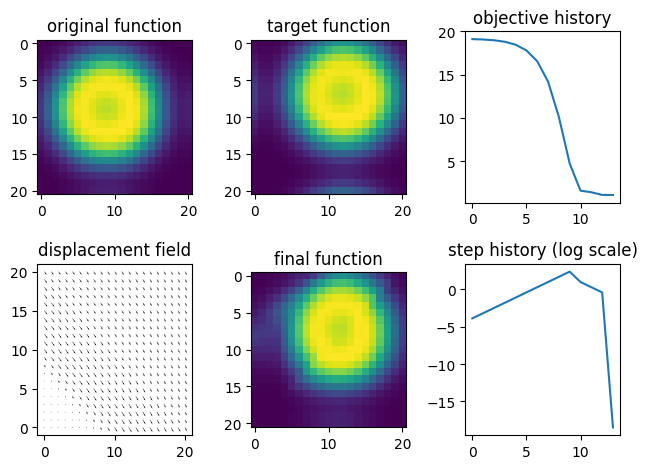

In [17]:
fig, ax = plt.subplots(2,3)
ax[0,0].imshow(f)
ax[0,0].set_title('original function')
ax[0,1].imshow(g)
ax[0,1].set_title('target function')
ax[1,0].quiver(ux,uy)
ax[1,0].set_title('displacement field')
ax[1,1].imshow(interpol(f,ux,uy))
ax[1,1].set_title('final function')
ax[0,2].plot(CF)
ax[0,2].set_title('objective history')
ax[1,2].plot(np.log(step))
ax[1,2].set_title('step history (log scale)')

plt.tight_layout()
plt.show()

# 5. Jeu des différences
Maintenant que vous avez implémenté et testé les deux algorithmes sur l'image-jouet proposée, voyons que cela donne sur une image IRM d'un cerveau. Saurez-vous détecter les différences/déplacements entre les deux images ?

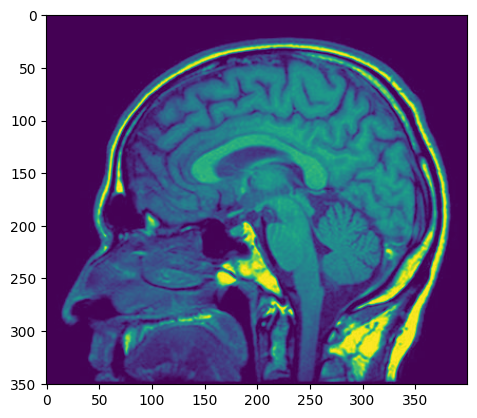

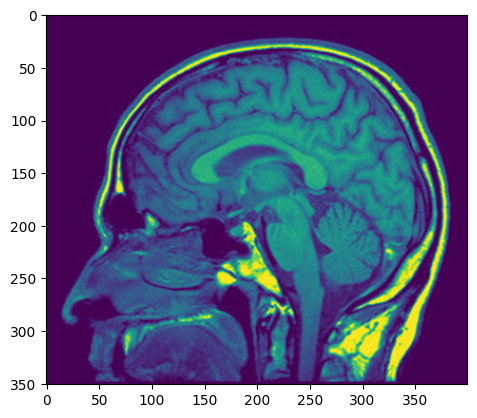

In [18]:
im1=Image.open('IRM1.png')
im2=Image.open("IRM2.png")
plt.imshow(plt.imread('IRM1.png'))
plt.show()
plt.imshow(plt.imread('IRM2.png'))
plt.show()

In [19]:
[n,m]=im1.size
sigma=0.1
[X,Y]=np.meshgrid(np.linspace(-1,1,n),np.linspace(-1,1,m), indexing='xy')
Z=np.sqrt(X*X+Y*Y)
G=np.fft.fftshift(np.exp(-(X**2+Y**2)/sigma**2))
f=np.real(np.fft.ifft2(np.fft.fft2(G)*np.fft.fft2(im1)))
g=np.real(np.fft.ifft2(np.fft.fft2(G)*np.fft.fft2(im2))) 
f=f/np.max(f)
g=g/np.max(g)

In [20]:
epsi=0.01
stepini=0.01
nitermax = 5000
lamb = 0.0001
mu = 0.0001
ux,uy,CF,step=RecalageGN(f,g,lamb,mu,nitermax,stepini,epsi)

iteration : 3  cost function : 0.14378266568827164 step : 0.08
iteration : 6  cost function : 0.14351829452096376 step : 0.64
iteration : 9  cost function : 0.1414351184686401 step : 5.12
iteration : 12  cost function : 0.1266364822765856 step : 40.96
iteration : 15  cost function : 0.07370494050432123 step : 327.68
iteration : 18  cost function : 0.0551792656064297 step : 20.48
iteration : 21  cost function : 0.05450657568072016 step : 10.24


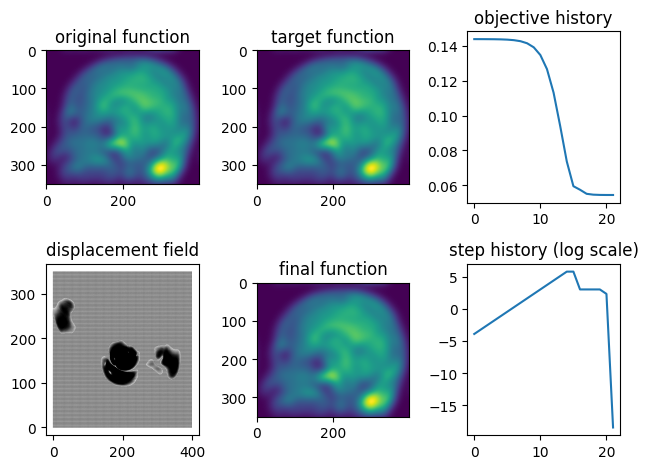

In [21]:
fig, ax = plt.subplots(2,3)
ax[0,0].imshow(f)
ax[0,0].set_title('original function')
ax[0,1].imshow(g)
ax[0,1].set_title('target function')
ax[1,0].quiver(ux,uy)
ax[1,0].set_title('displacement field')
ax[1,1].imshow(interpol(f,ux,uy))
ax[1,1].set_title('final function')
ax[0,2].plot(CF)
ax[0,2].set_title('objective history')
ax[1,2].plot(np.log(step))
ax[1,2].set_title('step history (log scale)')

plt.tight_layout()
plt.show()